In [49]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                nn.Dropout(),
                                nn.Linear(hidden_size,output_size))

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, (h1, c1) = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [50]:
import pandas as pd
file_path = './data/ETTm2.csv'
data = pd.read_csv(file_path)
data.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 00:15:00,39.622002,11.309,35.543999,8.551,3.209,1.258,38.223000
2,2016-07-01 00:30:00,38.868000,10.555,34.365002,7.586,4.435,1.258,37.344002
3,2016-07-01 00:45:00,35.518002,9.214,32.569000,8.712,4.435,1.215,37.124001
4,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001


In [51]:
import numpy as np
class LSTMDataSet(Dataset):
    def __init__(self, 
                 data, 
                 seq_len,
                 pred_len, 
                 train=True, 
                 test_size=0.2):
        self.seq_len = seq_len
        self.pred_len = pred_len
       
        if train:
            self.data_, _, = train_test_split(data, test_size=test_size,shuffle=False)
        else:
            _, self.data_ = train_test_split(data, test_size=test_size,shuffle=False)
        self.data = self.data_.astype(np.float32)
        self.data_len = self.data.shape[0] - seq_len - pred_len - 1

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        X = self.data[idx:idx+self.seq_len,:]
        y = self.data[idx+self.seq_len:idx+self.seq_len+self.pred_len,-1]
        return X, y

In [52]:
# Example usage
input_size = 7  # Example input size
hidden_size = 100
batch_size = 512
seq_len = 96
pred_len = 32
lr = 1e-4
num_epochs = 1_000

trainset = LSTMDataSet(data=data.values[:,1:],seq_len=seq_len,pred_len=pred_len,train=True)
testset = LSTMDataSet(data=data.values[:,1:],seq_len=seq_len,pred_len=pred_len,train=False)
trainloader = DataLoader(trainset,batch_size=batch_size,shuffle=False)
testloader = DataLoader(testset,batch_size=batch_size,shuffle=False)
output_size = pred_len  # Example output size

# Create a random input tensor
input_data = torch.randn(batch_size, seq_len, input_size)

# Create the model
model = LSTMModel(input_size, hidden_size, output_size)

# Forward pass
output = model(input_data)
print("Output shape:", output.shape)  # Expected output shape: (batch_size, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Output shape: torch.Size([512, 32])


LSTMModel(
  (lstm): LSTM(7, 100, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=100, out_features=32, bias=True)
  )
)

In [78]:
checkpoint = torch.load('./checkpoint2000.pth')
model.load_state_dict(checkpoint['state_dict'])
start_epoch = checkpoint['epoch']+1
#train_log,test_log = np.zeros(start_epoch+num_epochs,),np.zeros(start_epoch+num_epochs,)
#train_log[:start_epoch] = checkpoint['train_log']
#test_log[:start_epoch] = checkpoint['test_log']
train_log = checkpoint['train_log']
test_log = checkpoint['test_log']

In [54]:
start_epoch = 0
train_log,test_log = np.zeros(start_epoch+num_epochs,),np.zeros(start_epoch+num_epochs,)

In [55]:
with tqdm(total=num_epochs) as pbar:
    pbar.update(0)
    for epoch in range(num_epochs):
        epoch_loss = 0
        model.train()
        for inputs_,targets_ in trainloader:
            inputs,targets = inputs_.to(device),targets_.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            batch_loss = loss.item()
            epoch_loss += batch_loss*inputs.size(0)
        epoch_loss /= trainset.__len__()
        model.eval()
        test_epoch_loss = 0
        for inputs_,targets_ in testloader:
            inputs,targets = inputs_.to(device),targets_.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            batch_loss = loss.item()
            test_epoch_loss += batch_loss*inputs.size(0)
        test_epoch_loss /= testset.__len__()
        train_log[start_epoch+epoch] = epoch_loss
        test_log[start_epoch+epoch] = test_epoch_loss
        pbar.set_postfix(train_loss=epoch_loss,test_loss=test_epoch_loss,epoch=start_epoch+epoch+1)
        pbar.update(1)
        

  0%|          | 1/1000 [00:05<1:38:21,  5.91s/it, epoch=1, test_loss=11.1, train_loss=8.35]


KeyboardInterrupt: 

In [1]:
checkpoint = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'train_log': train_log,
    'test_log':test_log}
torch.save(checkpoint, f"{pred_len}checkpoint{start_epoch+epoch+1}.pth")

NameError: name 'epoch' is not defined

In [56]:
for inputs_,targets_ in trainloader:
    inputs,targets = inputs_.to(device),targets_.to(device)
    break

In [57]:
inputs.shape

torch.Size([512, 96, 7])

In [58]:
outputs = model(inputs)
output.shape

torch.Size([512, 32])

In [59]:
outputs = model(inputs)

In [60]:
inputs.shape,outputs.shape,targets.shape

(torch.Size([512, 96, 7]), torch.Size([512, 32]), torch.Size([512, 32]))

In [61]:
model.eval()

LSTMModel(
  (lstm): LSTM(7, 100, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=100, out_features=32, bias=True)
  )
)

Text(0, 0.5, 'Oil Temperature')

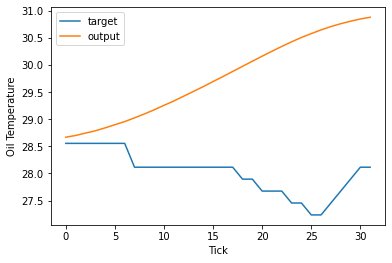

In [73]:
ii = 102
plt.plot(targets.cpu()[ii])
plt.plot(outputs.detach().cpu()[ii])
plt.legend(['target', 'output'])
plt.xlabel('Tick')
plt.ylabel('Oil Temperature')

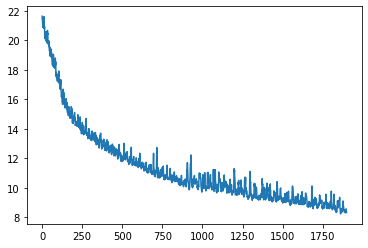

In [79]:
plt.plot(train_log[100:])

In [81]:
train_log[-1:]

array([8.32295297])

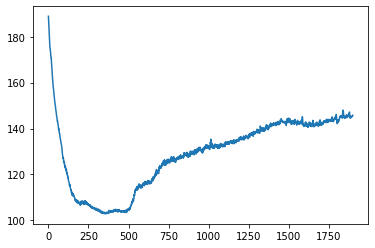

In [47]:
plt.plot(test_log[100:])

In [88]:
model2 = model = LSTMModel(input_size, hidden_size, output_size).to(device)
checkpoint2 = torch.load('./32wav_checkpoint1000.pth')
model2.load_state_dict(checkpoint['state_dict'])
start_epoch = checkpoint['epoch']+1
#train_log,test_log = np.zeros(start_epoch+num_epochs,),np.zeros(start_epoch+num_epochs,)
#train_log[:start_epoch] = checkpoint['train_log']
#test_log[:start_epoch] = checkpoint['test_log']
train_log2 = checkpoint2['train_log']
test_log2 = checkpoint2['test_log']

Text(0, 0.5, 'loss')

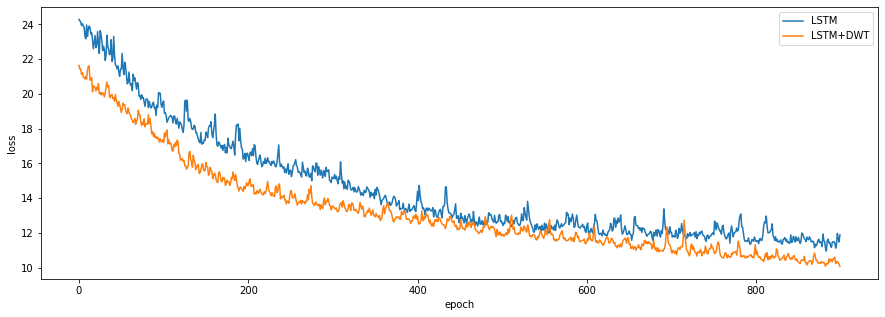

In [94]:
plt.figure(figsize=(15,5))
plt.plot(train_log2[100:])
plt.plot(train_log[100:1000])
plt.legend(['LSTM','LSTM+DWT'])
plt.xlabel('epoch')
plt.ylabel('loss')